In this issue of Beacondigest, the main theme is to try and quantify and measure the extent of decentralization in the PoS Ethereum system. We begin by introducing three metrics which are used to measure the levels of inequality in a system - Gini coefficient, Nakamoto coefficient and the Herfindahl–Hirschman index. We then use these metrics to calculate the extent of decentralization in PoS Ethereum and build some intuition on what these measures indicate.

Finally we conclude with the recurring portion of our biweekly notebooks - assessing the health of the network.

## Major staking entities in PoS Ethereum

As we explored earlier, a significant portion of the ETH staked on the Beacon Chain is concentrated in the hands of a few major entities. These entities include large staking pools, exchanges and whales. Some of the significant ones inlucde:

1) Kraken: They are a United States-based cryptocurrency exchange. One of the services that the exchange offers its users is asset staking, where the exchange uses the coins deposited by its users to stake on the Beacon Chain through a handful of trusted node operators. The staking rewards are then shared between users, node operators and the exchange itself.

2) Binance: They are another centralized cryptocurrency exchange where asset staking works in a manner similar to Kraken. Major differences in the two platforms include differences in platform fees, return rates and lock-in periods.  

3) Lido: As we saw in the [previous notebook](../05/staking_pools.html), Lido is a staking protocol that aims to provide liquidity to its users through its novel ERC20 token - stETH which is pegged 1:1 on ETH deposited by users that stake using the Lido protocol. 

In order to thus get a clear idea on just how much staked ETH these major entities control, we first look into the distribution of deposits among the 14 largest entities. We get this from the data that we previously scraped for our [Oceanic Games analysis](../../06/21/oceanic2.html).

In [ ]:
import sys
!{sys.executable} -m pip install tabulate
from tabulate import tabulate

In [70]:
from web3 import Web3
import json
import requests
import csv
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from time import *
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go
import math
import warnings

In [8]:
staking_pools = pd.read_csv('staking_pools.csv')
nan_value = float("NaN")
staking_pools.replace("", nan_value, inplace=True)
staking_pools.dropna(subset = ["Service"], inplace=True)

In [44]:
df = pd.read_csv('staking_pools.csv')
df['Percentage Stake'] = (df['Stake']/df['Stake'].sum())
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["Service"], inplace=True)
#df

In [10]:
df2 = df
lst = df2.index[df['Stake'] > 0].tolist()
d = {}

for i in lst:
    if(d.get(df2['Service'][i]) != None):
        d[df2['Service'][i]] += df2['Percentage Stake'][i]
    else:
        d[df2['Service'][i]] = df2['Percentage Stake'][i]

df2 = pd.DataFrame(d.items())
df2.rename(columns = {0: "service", 1: "percentage_stake"}, inplace=True)
df2 = df2.sort_values('percentage_stake',ascending=False)
df1 = df2.head(14)

In [11]:
dict_append = {'service': 'Others', 'percentage_stake': 1- df1['percentage_stake'].sum()}
#df1 = df1.append(dict_append, ignore_index=True)
df1

,service,percentage_stake
0,Kraken,0.145224
1,Binance,0.057429
2,Whale,0.041999
3,Lido,0.035372
4,Bitcoin Suisse,0.033422
5,Staked.us,0.025786
6,Stakefish,0.021061
7,Huobi,0.016219
8,Defi,0.012037
9,Stkr,0.009317


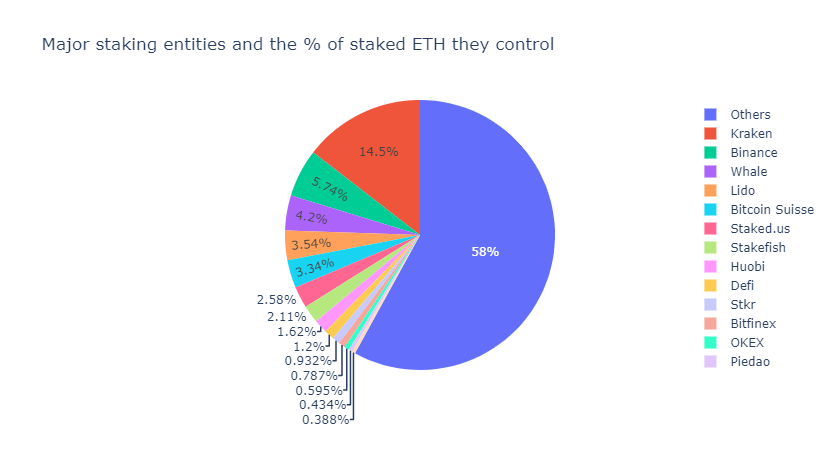

In [12]:
fig = px.pie(df1, values='percentage_stake', names='service', labels = {'service': 'Service', 'percentage_stake': 'Percentage'}, title = 'Major staking entities and the % of staked ETH they control')
fig.show()

## Measures of wealth inequality 

### Gini coefficient and Lorenz curve

In traditional economics, the Gini coefficient or the Gini index is a measure of wealth inequalities that exist within a given population. 

The Lorenz curve is essentially the graph that is obtained from plotting the cumulative % of the population  to the cumulative % of wealth or participation. The basic concept is put forth in this diagram below [Also explained in more detail with 2 examples later in the same section]: 

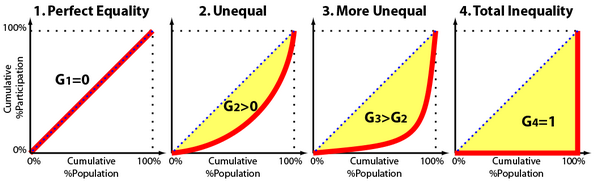

<sub>(figure by [Matthew John](https://www.quora.com/What-is-the-Gini-coefficient/answer/Matthew-John-69))</sub>

Subsiquently, the formula to calculate the Gini coefficient is as follows [Also explained in more detail with 2 examples later in the same section]:

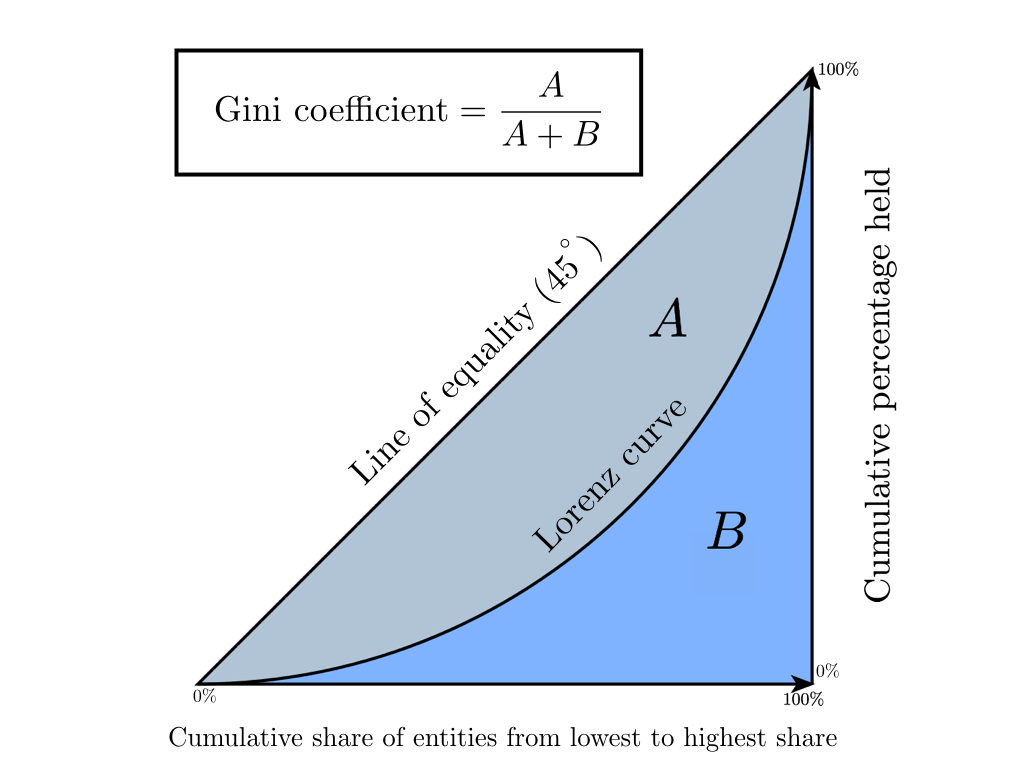

<sub>(figure by [Balaji Srinivasan](https://news.earn.com/quantifying-decentralization-e39db233c28e))</sub>

In order to calculate the decentralization of Blockchain systems, the "wealth inequality" can be compared to inequalities in the distribution of block rewards for honest block proposers and the population can be compared to active validators in ETH staking.

To get a better understanding of this metric let us consider the following 2 examples:

1) **CASE 1**: Consider a situation where there are 10 staking entities which control equal amounts of ETH staked in the Beacon Chain. Thus according to the [specs](https://github.com/ethereum/eth2.0-specs), all block proposer rewards should be split equally among them.

2) **CASE 2**: Consider a situation where there are 10 staking entities among which one entity controls almost all (around 99%) the ETH staked in the Beacon Chain. Thus, most of the block proposer rewards should be go to validators that belong to that entity, and in a given timeframe it can be argued that it is likely that all blocks produced in that timeframe are by proposers belonging to this entity. 

The Lorenz curve for these two situations would look something like this:

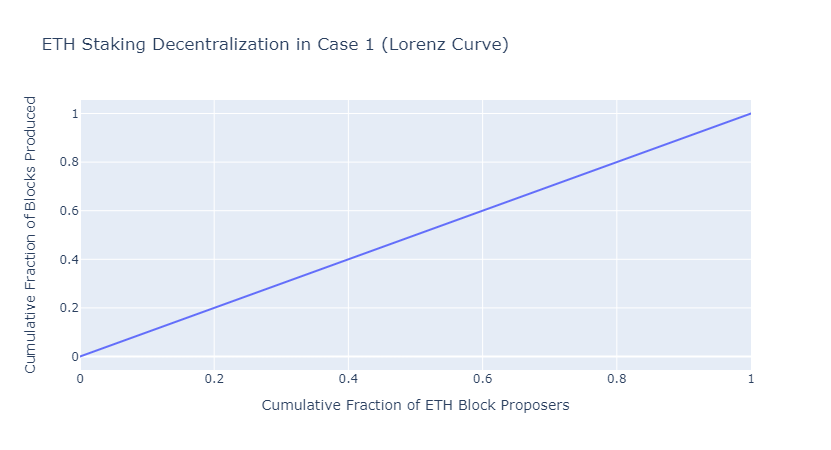

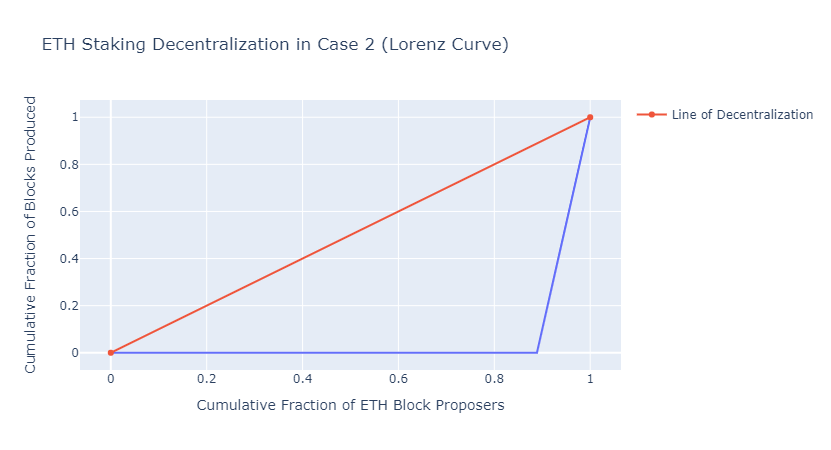

In [202]:
#In order to run this chunk of code please run the blocks of code contaning the function definitions first (later in the notebook)

list_case_1 = np.array([1,1,1,1,1,1,1,1,1])
list_case_2 = np.array([0,0,0,0,0,0,0,0,1]) 

lorenz_curve_case_1 = lorenz(list_case_1)
lorenz_curve_case_2 = lorenz(list_case_2)


fig = px.line(y = lorenz_curve_case_1, x = lorenz_curve_case_1, title = "ETH Staking Decentralization in Case 1 (Lorenz Curve)", labels = {"x": "Cumulative Fraction of ETH Block Proposers", "y": "Cumulative Fraction of Blocks Produced"})
#fig.add_scatter(x = [0,1], y = [0,1], name = "Line of Decentralization")
fig.show()

fig = px.line(y = lorenz_curve_case_2 , x = lorenz_curve_case_1, title = "ETH Staking Decentralization in Case 2 (Lorenz Curve)", labels = {"x": "Cumulative Fraction of ETH Block Proposers", "y": "Cumulative Fraction of Blocks Produced"})
fig.add_scatter(x = [0,1], y = [0,1], name = "Line of Decentralization")
fig.show()


Thus we can conclude that in case 1 which depicts a scenario of perfect decentralization the Lorenz curve is essentially a 45-degree line (Coincides with the line of decentralization) and in case 2 which depicts a scenario of total centralization, the curve becomes almost a vertical line. The corresponding Gini coefficients would be as given below:

In [37]:
table_gini = [['Gini coefficient for Case 1', gini(list_case_1)]]
print(tabulate(table_gini, tablefmt='fancy_grid'))

table_gini = [['Gini coefficient for Case 2', gini(list_case_2)]]
print(tabulate(table_gini, tablefmt='fancy_grid'))

╒═════════════════════════════╤═══╕
│ Gini coefficient for Case 1 │ 0 │
╘═════════════════════════════╧═══╛
╒═════════════════════════════╤══════════╕
│ Gini coefficient for Case 2 │ 0.888889 │
╘═════════════════════════════╧══════════╛


#### Data collection

In order to find the Gini coefficient and plot the Lorenz curve to measure the extent of decentralization in PoS Ethereum, we start off with collecting the data on the number of blocks proposed by different validators in the range of epochs 50445 - 50995 (this represents 550 epochs).

We then trace back the execution layer addresses of the entities that activated these validators using deposits of 32 ETH. We further compare to which entity this address belongs to (if any) using the staking pools mini-database we compiled for our previous analysis. 

In [15]:
# proposer_list = []

In [22]:
# with open('api_key.txt', 'r') as api_file:
#     api_key = api_file.read()

for epoch in range(50445,50995):
    x = requests.get('https://beaconcha.in/api/v1/epoch/{}/blocks?api_key={}'.format(epoch, "dDQvWWNGZzhxaTlZRC5id01rT1gu"))
    #Add a sleep to stay within the call rate limits
    sleep(6)
    
    data = x.json()['data']
    
    for i in data:
        proposer_list.append(i['proposer'])


In [23]:
# with open('proposer_indices.csv', 'w', newline='') as myfile:
#      wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#      wr.writerow(proposer_list)

In [5]:
with open('proposer_indices.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

print(len(data[0]))

17505


Thus in this range of epochs, 17505 blocks were produced 

In [ ]:
staking_entities = []
indices_list = []

In [ ]:
for i in range(0,len(data[0]) + 1, 100):
    str1 = ''
    
    if i<=17400:
        for j in range(99):
            str1 = str1 + str(data[0][i+j]) + ','
        str1 = str1 + str(data[0][i+99])

#             str1 = str1 + str(i+j) + ','
#         str1 = str1 + str(i+99)
        
    else:
        for j in range(5):
            str1 = str1 + str(data[0][i+j]) + ','
        str1 = str1 + str(data[0][i+4])
#                 str1 = str1 + str(i+j) + ','
#         str1 = str1 + str(i+4)

    #print(str1)
    indices_list.append(str1)
    
#     x = requests.get('https://beaconcha.in/api/v1/validator/{}/deposits?api_key={}'.format(str1, "dDQvWWNGZzhxaTlZRC5id01rT1gu"))
#     #Add a sleep to stay within the call rate limits
#     sleep(6)
    
#     data = x.json()['data']
    
#     for t in data:
#         staking_entities.append(t['from_address'])

In [ ]:
for i in indices_list:
    x = requests.get('https://beaconcha.in/api/v1/validator/{}/deposits?api_key={}'.format(i, "dDQvWWNGZzhxaTlZRC5id01rT1gu"))
    #Add a sleep to stay within the call rate limits
    sleep(6)
    
    data = x.json()['data']
    
    for t in data:
        staking_entities.append(t['from_address']

In [ ]:
# with open('proposer_addresses.csv', 'w', newline='') as myfile:
#      wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#      wr.writerow(staking_entities)

In [6]:
with open('proposer_addresses.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    
data = data[0]
#data

In [39]:
df = df[['Address','Service']]
df
address_list = df.values.tolist()
address_list

address_dict = {}

for i in address_list:
    address_dict[i[0]] = i[1]

#address_dict

In [ ]:
gini_dict = {}

for i in data:
    
    if i in address_dict:
        if address_dict[i] in gini_dict:
            gini_dict[address_dict[i]] += 1
        else:
            gini_dict[address_dict[i]] = 1
    else:
        if i in gini_dict:
            gini_dict[i] += 1
        else:
            gini_dict[i] = 1
            
gini_dict        

#### Analysis

In [1]:
def gini(array):
    array = array.flatten() 
    array = np.sort(array) 
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) 

In [16]:
gini_input = list(gini_dict.values())
gini_input = np.array(gini_input)

In [237]:
table_gini = [['Gini coefficient', gini(gini_input)]]
print(tabulate(table_gini, tablefmt='fancy_grid'))

╒══════════════════╤══════════╕
│ Gini coefficient │ 0.688628 │
╘══════════════════╧══════════╛


We thus calculate the Gini coefficient of the PoS Ethereum system to be roughly around 0.689. This is an indication of a more serious gap among staking entities with regards to the resources they possess. 

To build a more concrete understanding of this value, <span class="reference bibliography" refid="researchgateans"></span> a Gini score of 0.689 would essentially mean that if we take any two staking entities at random, the difference in block rewards they posses is expected to be 1.37 times the mean.

When we plot the Lorenz curve, we get the following plot

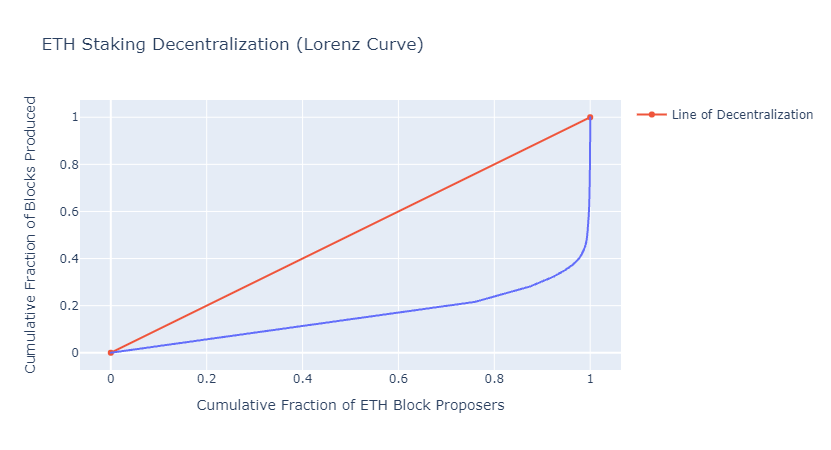

In [31]:
def lorenz(arr):
    arr = np.sort(arr)
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    return np.insert(scaled_prefix_sum, 0, 0)

lorenz_curve = lorenz(gini_input)


fig = px.line(x = np.linspace(0.0, 1.0, lorenz_curve.size) , y = lorenz_curve, title = "ETH Staking Decentralization (Lorenz Curve)", labels = {"x": "Cumulative Fraction of ETH Block Proposers", "y": "Cumulative Fraction of Blocks Produced"})
fig.add_scatter(x = [0,1], y = [0,1], name = "Line of Decentralization")
fig.show()

We observe a significant deviation from the 45-degree line, indicating a decently high level of centralization.

### Nakamoto coefficient

The Nakamoto coefficient, as presented in the paper _Measuring Decentralization in Bitcoin and Ethereum using Multiple Metrics and Granularities_ <span class="reference bibliography" refid="lichao2021"></span>. By definition, the Nakamoto coefficient simply is the minimum number of entities needed to collude to take control of 51% of the ETH staked on the network.

It can be calculated using the formula:

$$N = min( k \in [1,2,...K]: \sum_{i=1}^{k} p_{i} \geq 0.51)$$

Where $p_{i}$ represents the percentage of blocks produced by entity $i$ and $K$ is the total number of entities in the system

#### Data collection

We use the same data we collected while calculating the Gini coefficient after selecting only the columns relavant to us ("Proposer" and "Number of Blocks Proposed") and adding another column ("Percentage Proposed").

We then plot a pie chart that represents the 10 major entities that proposed the most number of blocks during the given range of epochs. 

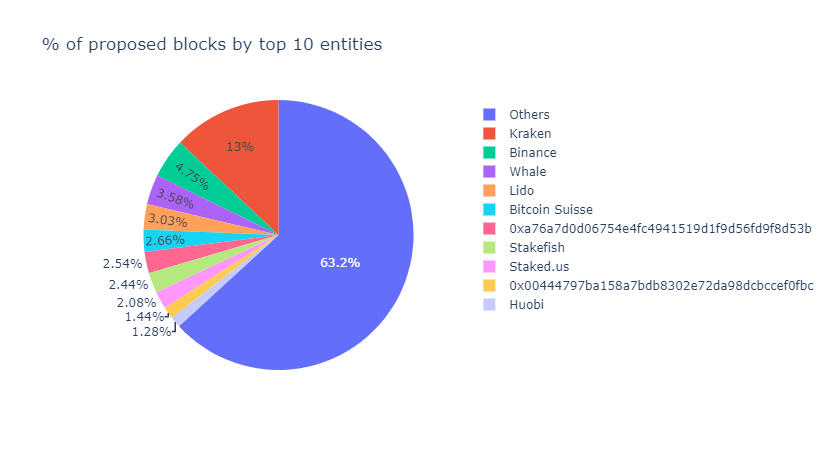

In [57]:
nakamoto_df = pd.DataFrame(gini_dict.items(), columns = ["Proposer", "Number of Blocks Produced"])
nakamoto_df['Percentage Proposed'] = (nakamoto_df['Number of Blocks Produced']/nakamoto_df['Number of Blocks Produced'].sum())
nakamoto_df = nakamoto_df.sort_values(by='Percentage Proposed', ascending=False)
display_nakamoto = nakamoto_df[['Proposer', 'Percentage Proposed']]
display_nakamoto = display_nakamoto.head(10)
dict_append = {'Proposer': 'Others', 'Percentage Proposed': 1- display_nakamoto['Percentage Proposed'].sum()}
display_nakamoto = display_nakamoto.append(dict_append, ignore_index=True)
fig = px.pie(display_nakamoto, values='Percentage Proposed', names='Proposer', title = '% of proposed blocks by top 10 entities')
fig.show()

#### Analysis

In order to measure the extent of decentralization in PoS Ethereum using this metirc, we thus find the minimum number of parties needed to collude to control > 33%, > 50% and > 66% of the network. As a reminder, an entity owning over 33% of the stake can successfully prevent the system from finalizing, until its stake "leaks" due to penalties or unless it is forked out of the system.

In [74]:
nakamoto_df['Cumulative Percentage Proposed'] = nakamoto_df['Percentage Proposed'].cumsum()
display_table = nakamoto_df.head(10)
index = [1,2,3,4,5,6,7,8,9,10]
display_table[''] = index
display_table.set_index('')

,Proposer,Number of Blocks Produced,Percentage Proposed,Cumulative Percentage Proposed
,,,,
1,Kraken,2278,0.129956,0.129956
2,Binance,832,0.047464,0.177420
3,Whale,628,0.035826,0.213247
4,Lido,531,0.030293,0.243539
5,Bitcoin Suisse,466,0.026585,0.270124
6,0xa76a7d0d06754e4fc4941519d1f9d56fd9f8d53b,446,0.025444,0.295567
7,Stakefish,428,0.024417,0.319984
8,Staked.us,365,0.020823,0.340807
9,0x00444797ba158a7bdb8302e72da98dcbccef0fbc,252,0.014376,0.355183


In [233]:
table_nakamoto = [['Number of parties needed to collude to control > 33%', len(nakamoto_df[nakamoto_df['Cumulative Percentage Proposed'] <= 0.33]) + 1], ['Number of parties needed to collude to control > 50%', len(nakamoto_df[nakamoto_df['Cumulative Percentage Proposed'] <= 0.50]) + 1], ['Number of parties needed to collude to control > 66%', len(nakamoto_df[nakamoto_df['Cumulative Percentage Proposed'] <= 0.66]) + 1]]

In [234]:
print(tabulate(table_nakamoto, tablefmt='fancy_grid'))

╒══════════════════════════════════════════════════════╤═════╕
│ Number of parties needed to collude to control > 33% │   8 │
├──────────────────────────────────────────────────────┼─────┤
│ Number of parties needed to collude to control > 50% │  31 │
├──────────────────────────────────────────────────────┼─────┤
│ Number of parties needed to collude to control > 66% │ 309 │
╘══════════════════════════════════════════════════════╧═════╛


Thus, the Nakamoto score of the system is 31, meaning that at least 31 parties need to come together in order to take control of 51% of the network. 

However the minimum number of parties needed to colluto to control more than 33% of the network is just 8 meaning that with just 8 entities, liveness can be indefinitely delayed. 

To cause extreme damage to the system, an attacker would need at least 66% control over the network which can only be achieved if at least 309 entities come together and collude which is pretty infeasible.

### Herfindahl–Hirschman Index

The final metric we look at is the Herfindahl–Hirschman Index. This metric is known to measure the size of the staking pools in relation to the collective size of the entire ETH Staking industry. It is also an indication of the amount of competition among staking entities. 

The formula to calculate this score is as follows:

$$ H = \sum_{i=1}^{N} s_{i}^2 $$

where $s_{i}$ is the percentage of ETH staked by entity $i$ and $N$ represents the total number of staking entities. 

In order to make sense of the different values for this index we can use the table given below as a reference

In [75]:
table_hhi_reference = [['H below 0.01:', 'highly competitive industry'], ['H below 0.15:', 'unconcentrated industry'], ['H between 0.15 to 0.25:', 'moderate concentration'], [' H above 0.25:', 'high concentration']]
print(tabulate(table_hhi_reference, tablefmt='fancy_grid'))

╒═════════════════════════╤═════════════════════════════╕
│ H below 0.01:           │ highly competitive industry │
├─────────────────────────┼─────────────────────────────┤
│ H below 0.15:           │ unconcentrated industry     │
├─────────────────────────┼─────────────────────────────┤
│ H between 0.15 to 0.25: │ moderate concentration      │
├─────────────────────────┼─────────────────────────────┤
│ H above 0.25:           │ high concentration          │
╘═════════════════════════╧═════════════════════════════╛


#### Data collection

We continue to use the data that we initially collected for measuring the Gini coefficient but this time keeping only the 'Proposer' and 'Percentage Proposed' columns 

#### Analysis

When we calculate the HHI index using the above formula this is what we get:

In [77]:
hhi_df = nakamoto_df[['Proposer', 'Number of Blocks Produced']]
temp = 0
for i in hhi_df['Percentage Proposed']:
    temp += i**2
    
hhi_score = temp

In [240]:
table_gini = [['Herfindahl–Hirschman Index', hhi_score]]
print(tabulate(table_gini, tablefmt='fancy_grid'))

╒════════════════════════════╤═══════════╕
│ Herfindahl–Hirschman Index │ 0.0252203 │
╘════════════════════════════╧═══════════╛


Going by the table, this is indicative of a very competitive industry which is highly unconcentrated. This might be due to the fact that in our dataset we have included a large "ocean" of validators who have produced only one or two blocks during the range of epochs we have considered. 

It would also be useful for us to measure the extent of competition among only the 10 largest staking entities to see how competitive each individual entity is and more importantly how collusion-proof they are, which is in a way safeguarding the security of the protocol by having wealth distributed among many "atomic players" instead of just a single entity. A good parallel to this is an [Oligarchy](https://en.wikipedia.org/wiki/Oligarchy) vs an [Autocracy](https://en.wikipedia.org/wiki/Autocracy).

In [90]:
hhi_df_further = nakamoto_df[['Proposer', 'Number of Blocks Produced']].head(10)
hhi_df_further['Percentage Proposed'] = (hhi_df_further['Number of Blocks Produced']/hhi_df_further['Number of Blocks Produced'].sum())

In [91]:
temp = 0
for i in hhi_df_further['Percentage Proposed']:
#     print(i)
    temp += i**2
    
hhi_score = temp

In [92]:
table_gini = [['Herfindahl–Hirschman Index for the 10 largest staking entities', hhi_score]]
print(tabulate(table_gini, tablefmt='fancy_grid'))

╒════════════════════════════════════════════════════════════════╤══════════╕
│ Herfindahl–Hirschman Index for the 10 largest staking entities │ 0.177926 │
╘════════════════════════════════════════════════════════════════╧══════════╛


Mathematically finding the HHI Index by taking 10 of the largest staking entities would given a lowest possible value of 0.1. The score we get by applying this to PoS Ethereum is around 0.178, which is not too far from the minimum.


## Limitations to the notebook

The major shortcoming of our analysis is that the time period of 550 epochs might be too small to accurately estimate the distribution of block rewards among proposers.

In order to overcome this shortcoming we propose to collect data for a larger epoch period and also looking at these measurement quantities over time (daily, weekly and monthly)

## The Beacon Chain Digest - July 19th

This fortnight's version of the recurring Beacon Chain analysis, the format we follow is a little different from the previous editions. Instead of analysing the data from the past 14 days we:

1) Visualize how many deposits have been made to the Beacon Chain over time since May 24th

2) View how the validators have performed from May 24th till July 19th in terms of - participation rates and the number of blocks produced

### Deposits 

The number of deposits being made to activate validators in the Beacon Chain has been increasing over time and recently the number of staking pools and larger entities  making large deposits at descrete time intervals  to activate a large number of validators at once, has said to be getting higher. 

In order to explore this we use data starting from Epoch 39121 (May 24th, 8:54AM GMT) till Epoch 51630 (Jul 19th, 7:12AM GMT) and plot our usual graph to get a sense on how many deposits were made during this period.  

As usual we start with processing our data

In [109]:
li = []

all_files = ["deposits 1.csv", "deposits 2.csv", "deposits 3.csv", "deposits 4.csv"]
use_cols = [0,1]
names = ["Epoch", "Deposits"]

for file in all_files:
    df = pd.read_csv(file, header = None, names = names, usecols = use_cols)
    li.append(df)

df_deposits = pd.concat(li)

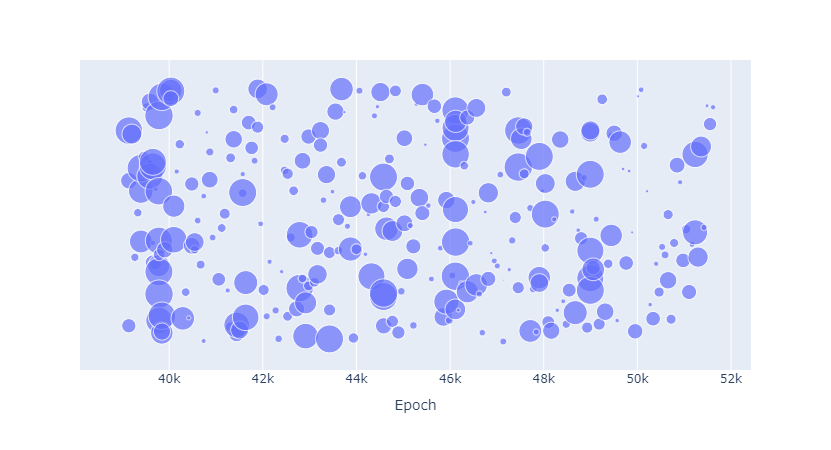

In [115]:
rng = np.random.default_rng(42)
df_deposits['temp'] = rng.uniform(0, 10, len(df_deposits["Epoch"]))
fig = px.scatter(
    df_deposits[df_deposits["Deposits"] > 0], x = 'Epoch', y = 'temp', size = 'Deposits',
    size_max = 20, labels = {"Epoch": "Epoch"})
fig.update_yaxes(visible=False)

We find that the number of large deposits made at descrete time periods is a lot higher during the first few sets of epochs.

Another interseting point to note is that judging by the size of the deposits, it is a fair assumption that at least at this range in time, the number of new validators staking through 3rd party staking services are a lot higher than new solo-stakers.

### Participation rate

In order to analyze how the network has been performing in terms of this metric over time, we split the number of epochs into intervals of 225 epochs (1 Day) and plot the average participation rate for that time interval 

In [181]:
li = []

all_files = ["GPR1.csv", "GPR2.csv", "GPR3.csv", "GPR4.csv"]
use_cols = [0,1]
names = ["Epoch", "Participation Rate"]

for file in all_files:
    df = pd.read_csv(file, header = None, names = names, usecols = use_cols)
    li.append(df)

df_participation_rate = pd.concat(li)

In [182]:
nan_value = float("NaN")

df_participation_rate.replace("", nan_value, inplace=True)

df_participation_rate.dropna(subset = ["Participation Rate"], inplace=True)

In [183]:
average_participation_list = []
df_list = []
x_axis_list = []
count = 0

for i in range(225,12364,225):
    df_list.append(df_participation_rate[i - 225:i])
    x_axis_list.append(count)
    count += 1

In [184]:
for i in df_list:
    average_participation_list.append(i['Participation Rate'].mean())

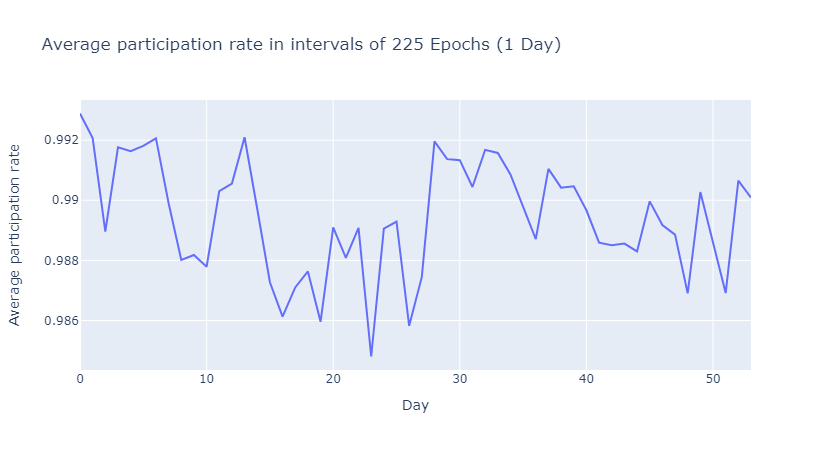

In [185]:
fig = px.line(x= x_axis_list, y= average_participation_list, title='Average participation rate in intervals of 225 Epochs (1 Day)', labels = {'x': 'Day', 'y': 'Average participation rate'})
fig.show()

We notice that the average participation rate per day infact varies quite stochastically without any visible pattern. However, this metric never went below 0.98 which is a sign of a healthy network

### Number of blocks produced

Finally to assess the validators' performace over this time period, we plot a histogram that captures the number of times blocks 'X' blocks were produced in an epoch

In [199]:
li = []

all_files = ["BC1.csv", "BC2.csv", "BC3.csv", "BC4.csv"]
use_cols = [0,1]
names = ["Epoch", "Number of Blocks Produced"]

for file in all_files:
    df = pd.read_csv(file, header = None, names = names, usecols = use_cols)
    li.append(df)

df_blocks_produced = pd.concat(li)

In [200]:
nan_value = float("NaN")

df_blocks_produced.replace("", nan_value, inplace=True)

df_blocks_produced.dropna(subset = ["Number of Blocks Produced"], inplace=True)

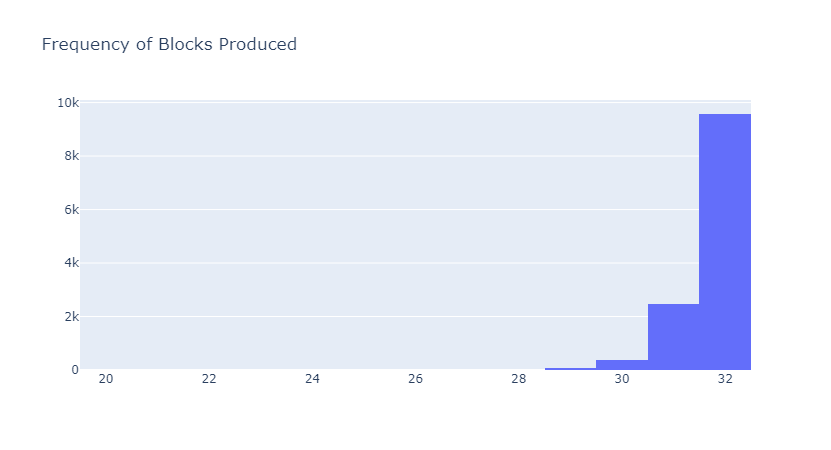

In [201]:
x = df_blocks_produced["Number of Blocks Produced"]

trace = go.Histogram(x=x)

layout = go.Layout(
    title="Frequency of Blocks Produced"
)

fig = go.Figure(data=go.Data([trace]), layout=layout)
fig.show()

As expected, the number of blocks produced per epoch almost always lied in the range of 31-32. There was however one epoch during which this number fell all the way down to 20, the reason for which might be worth exploring.